In [5]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [6]:
! pip install -q kaggle 

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pritindradas","key":"96dcf9875f27887a60af48bde9ff3211"}'}

In [17]:
! ls 


kaggle.json  sample_data


In [18]:
! cp 'kaggle.json' ~/.kaggle/

In [19]:
! chmod 600 ~/.kaggle/'kaggle.json'

In [20]:
!kaggle datasets download -d fournierp/captcha-version-2-images



 29% 5.00M/17.4M [00:00<00:00, 42.9MB/s]
100% 17.4M/17.4M [00:00<00:00, 85.5MB/s]


In [21]:
! ls

captcha-version-2-images.zip  kaggle.json  sample_data


In [22]:
! unzip captcha-version-2-images.zip

Archive:  captcha-version-2-images.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2cegf.png       
  inflating: samples/2cg58.png       
  inflating: samples/2cgyx.png       
  inflating

In [23]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
path = "./samples"


In [24]:
# Adaptive Thresh holding images
def TH_img(img):
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)    

# Closing images
def C_img(img):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint(8)))

# Dilating images
def D_img(img):
    return cv2.dilate(img, np.ones((2,2), np.uint(8)), iterations = 1)

# Smoothing images
def Sm_img(img):
    return cv2.GaussianBlur(img, (1,1), 0)

In [25]:
# appending to all images
X = []
Y = []
for image in os.listdir(path):
    if image[6:] != "png":
        continue
    
    img = cv2.imread(os.path.join(path,image), cv2.IMREAD_GRAYSCALE)
    img = TH_img(img)
    img = C_img(img)
    img = D_img(img)
    img = Sm_img(img)
    
    img_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
     
    for i in range(5):
        X.append(tf.keras.preprocessing.image.img_to_array(Image.fromarray(img_list[i])))
        Y.append(image[i])

X = np.array(X)
Y = np.array(Y)

In [26]:
print(X.shape)
print(Y.shape)

(5200, 40, 20, 1)
(5200,)


In [53]:
X /= 255.0

y_comb = LabelEncoder().fit_transform(Y)
y_one_hot = OneHotEncoder(sparse= False).fit_transform(y_comb.reshape(len(y_comb),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state=1)

In [55]:
info = {y_comb[i] : Y[i] for i in range(len(Y))}

In [28]:
def cn_layer(fx):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Conv2D(fx,(3,3), activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    return model    

def fc_layer(hx):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(hx, activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    return model

In [29]:
def cnn(f1,f2,f3,h1,h2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer((40,20,1,)))

    model.add(cn_layer(f1))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"))
    model.add(cn_layer(f2))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"))
    model.add(cn_layer(f3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"))

    model.add(tf.keras.layers.Flatten())
    model.add(fc_layer(h1))
    model.add(fc_layer(h2))
    model.add(tf.keras.layers.Dense(19, activation = "softmax")) # 19 according to labels
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [30]:
traingen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5, width_shift_range=[-2,2])
traingen.fit(X_train)

In [31]:
model = cnn(128, 32, 16, 32, 32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 38, 18, 128)       1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 9, 128)        0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 17, 7, 32)         37024     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 4, 32)          0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 7, 2, 16)          4688      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 1, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [32]:
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20, verbose=1)
checkp = tf.keras.callbacks.ModelCheckpoint('./result_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)


In [34]:
history = model.fit(traingen.flow(X_train, y_train, batch_size = 32), validation_data = (X_test, y_test), epochs = 150, steps_per_epoch = len(X_train)/32, callbacks = [checkp])


Epoch 1/150
130/130 [==============================] - 2s 13ms/step - loss: 1.2978 - accuracy: 0.6248 - val_loss: 1.3050 - val_accuracy: 0.6692

Epoch 00001: val_loss improved from 3.11699 to 1.30499, saving model to ./result_model.h5
Epoch 2/150
130/130 [==============================] - 2s 14ms/step - loss: 1.1924 - accuracy: 0.6644 - val_loss: 0.9159 - val_accuracy: 0.7635

Epoch 00002: val_loss improved from 1.30499 to 0.91593, saving model to ./result_model.h5
Epoch 3/150
130/130 [==============================] - 2s 14ms/step - loss: 1.1001 - accuracy: 0.6947 - val_loss: 0.8296 - val_accuracy: 0.7817

Epoch 00003: val_loss improved from 0.91593 to 0.82961, saving model to ./result_model.h5
Epoch 4/150
130/130 [==============================] - 2s 14ms/step - loss: 1.0383 - accuracy: 0.7137 - val_loss: 0.8463 - val_accuracy: 0.7885

Epoch 00004: val_loss did not improve from 0.82961
Epoch 5/150
130/130 [==============================] - 2s 14ms/step - loss: 0.9492 - accuracy: 0.73

In [35]:
! ls

captcha-version-2-images.zip  result_model.h5  samples
kaggle.json		      sample_data


In [36]:
model = tf.keras.models.load_model('./result_model.h5')

In [58]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)
target_name = []
for i in sorted(info) :
    target_name.append(info[i])

In [62]:
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy : ' + str(accuracy_score(yres, pred)))
print(classification_report(yres, pred, target_names = target_name))

Accuracy : 0.06538461538461539
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        39
           4       0.07      1.00      0.12        68
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        49
           7       0.00      0.00      0.00        50
           8       0.00      0.00      0.00        61
           b       0.00      0.00      0.00        46
           c       0.00      0.00      0.00        54
           d       0.00      0.00      0.00        61
           e       0.00      0.00      0.00        41
           f       0.00      0.00      0.00        48
           g       0.00      0.00      0.00        54
           m       0.00      0.00      0.00        54
           n       0.00      0.00      0.00       113
           p       0.00      0.00      0.00        48
           w       0.00      0.00      0.00       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
import matplotlib.pyplot as plt

def get_demo (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    img = TH_img(img)
    img = C_img(img)
    img = D_img(img)
    img = Sm_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    Xdemo = []
    for i in range(5) :
        Xdemo.append(tf.keras.preprocessing.image.img_to_array(Image.fromarray(image_list[i])))
    
    Xdemo = np.array(Xdemo)
    Xdemo/= 255.0
    
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 1)
    
    for res in ydemo :
        print(info[res])
    print(img_path[-9:])

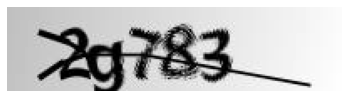

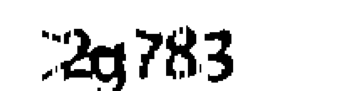

2
g
7
8
3
2g783.png


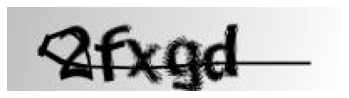

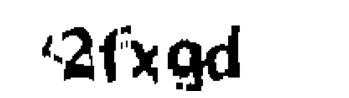

2
f
x
g
d
2fxgd.png


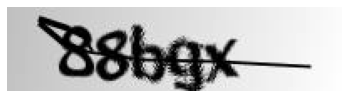

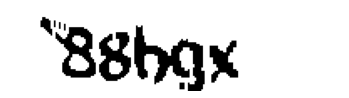

8
8
b
g
x
88bgx.png


In [56]:
get_demo('samples/2g783.png')
get_demo('samples/2fxgd.png')
get_demo('samples/88bgx.png')